In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress, ttest_ind
from Modules import plot_ax_violin
from sklearn.preprocessing import StandardScaler
import umap

from PyPDF2 import PdfFileWriter, PdfFileReader
import io
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

pdfmetrics.registerFont(TTFont('Arial', 'Arial.ttf'))

from Modules import sholl_analysis
from Modules import read_data
from Modules import generate_figures

In [2]:
def get_ephys_data():
    """
    get ephys data, adjusted with age information
    Outputs:
        df_ephys - pandas dataframe of ephys data
        df_labels - pandas dataframe of corresponding cell information
    """
    # read in the data
    # keep only vBC cells
    df_ephys = plot_ax_violin.read_ephys_data('Lab_Pvalb')
    df_ephys.index = df_ephys.index.get_level_values(0)
    df_ephys.index.name = 'Cell'
    df_labels = read_data.read_dataset_labels('Lab_Pvalb')
    df_labels = df_labels.loc[np.logical_or(df_labels.Age<21, df_labels.Age>21)]
    df_labels = df_labels.loc[df_labels.CellType=='vBC']
    df_labels = df_labels.loc[df_labels.index.isin(df_ephys.index),:].copy()
    
    # add label based on age of cell
    df_labels['Label'] = ''
    young = df_labels.Age<21
    mature = df_labels.Age>21
    df_labels.loc[young,'Label'] = '<P21'
    df_labels.loc[mature,'Label'] = '>P21'
    
    # rename ephys columns
    columns = [
               'Resting membrane potential (mV)', 'Input resistance (MOhm)', 'Capacitance (pF)',
               'AP firing threshold (pA)', 'AP symmetricity', 'AP peak amplitude (mV)', 
               'AP halfwidth (ms)', 'Frequency Slope (Hz/pA)', 'Attenuation',
               'Sag potential'
              ]
    column_names = [r'V$_{resting}$ (mv)',
                    r'R$_{input}$ (mΩ)',
                    'C (pF)',
                    'AP threshold (pA)',
                    'AP symmetricity',
                    'AP amplitude (mV)',
                    'AP halfwidth (ms)',
                    r'dF/dI$_{step}$ (Hz/pA)',
                    'Attenuation',
                    'Sag (mV)'
                   ]
    df_ephys = df_ephys.loc[df_labels.index,columns].copy()
    df_ephys.columns = column_names
    df_ephys.index = df_labels.Label

    return df_ephys, df_labels

def plot_ephys(fig, df, df_labels, ax):
    """
    plot ephys data
    Inputs:
        fig - figure to plot on
        df - pandas dataframe of ephys values
        df_labels - pandas dataframe of cell labels
        ax - axes for UMAP plot
    """
    # initialize variables
    celltypes = ('<P21', '>P21')
    df_marker = pd.read_csv('References/marker_ref.txt', sep='\t', header=0, index_col=0)
    params = {'left':.11,
              'right':.68,
              'row_count':5,
              'rotation':45,
              'ticklabels':celltypes,
              'df_marker':df_marker,
              'show_violin':False,
              'show_error':True,
              'show_box':False,
              'show_signif':True,
              'height':.116,
              'dh':.076,
              'labelsize':6,
              'ticksize':5,
              'ylabel_coords':(-0.325, 0.5),
              'show_median':False
             }
    
    # generate figure
    args = (fig, .62, df, celltypes)
    bot = plot_ax_violin.plot_generated_electrophys(*args, **params)
    
    # plot UMAP based on ephys data
    datalist = StandardScaler().fit_transform(df.values)
    reducer = umap.UMAP(n_components=2, n_neighbors=7, min_dist=.01, random_state=42, metric='euclidean')
    plotlist = reducer.fit_transform(datalist)
    index = pd.MultiIndex.from_arrays((df_labels.index, df_labels.Age), names=('Cell', 'Age'))
    columns = ['UMAP X-coordinate', 'UMAP Y-coordinate']
    df_umap = pd.DataFrame(plotlist, index=index, columns=columns)
    df_umap.to_csv('Mapping/Embeddings/Lab_Pvalb_vBC-electro.tsv', sep='\t')
    sholl_analysis.get_age_colors(df_labels)
    colors = df_labels.Color
    ax.scatter(plotlist[:,0], plotlist[:,1], facecolor=colors, edgecolor='#000000', linewidth=.25, s=16)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel(r'UMAP$_1$', fontsize=7)
    ax.set_ylabel(r'UMAP$_2$', fontsize=7)
    
    # add scale bars
    cax = fig.add_axes([.82, .296, .08, .011])
    sholl_analysis.plot_age_scale(df_labels.Age, cax)
    cax = fig.add_axes([.39, .90, .08, .011])
    sholl_analysis.plot_age_scale(df_labels.Age, cax)
    
    return

def plot_comparison(df, column, ylabel, ax, show_xticks=True):
    df = df.loc[~(df[column].isna())]
    
    # plot data
    xvals = 1 + .5*(np.random.rand(df.shape[0])-.5)
    xvals[df.Age<21] -= .5
    xvals[df.Age>21] += .5
    ax.scatter(xvals, df[column], facecolor=df.Color, s=8, edgecolor='k', linewidth=.25, zorder=0)
    
    # set up axis
    ax.axis([0,2,0,df[column].max()*1.2])
    ax.set_ylim(0,None)
    ax.tick_params(size=1, labelsize=6, pad=1)
    ax.set_xticks([.5,1.5])
    if show_xticks:
        ax.set_xticklabels(['<P21', '>P21'], rotation=45, ha='right')
    else:
        ax.set_xticklabels(['', ''])
    ax.set_ylabel(ylabel, fontsize=8)
    ax.yaxis.set_label_coords(-.4,.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # add statistics
    young = df.loc[df.Age<21, column].values
    old = df.loc[df.Age>21, column].values
    pval = ttest_ind(young, old, equal_var=False)[1]
    ax.text(.5, 1.0, r'$\it{p}$ = %.2f' % pval, fontsize=6, ha='center', va='center', transform=ax.transAxes)
    
    # mark statistics
    xvals = np.array([-.2,.2,0, 0,-.3,.3,0, 0, -.2,.2])
    yvals = np.array([-1,-1,-1, 0,0,0,0, 1,1,1])
    
    young_mean = young.mean()
    young_error = young.std() / np.sqrt(young.size-1)
    ax.plot(.5+xvals, young_mean+young_error*yvals, linewidth=1, color='k', zorder=1)
    
    old_mean = old.mean()
    old_error = old.std() / np.sqrt(young.size-1)
    ax.plot(1.5+xvals, old_mean+old_error*yvals, linewidth=1, color='k', zorder=1)
    
    return

def plot_comparisons(df, ax1, ax2):
    plot_comparison(df, 'Dendritic length (cm)', 'Dendrite\nlength (cm)', ax1, show_xticks=False)
    plot_comparison(df, 'Axon length (cm)', 'Axon\nlength (cm)', ax2, show_xticks=True)
    
    return

In [3]:
df = sholl_analysis.get_sholl_data()
df_ephys, df_ephys_labels = get_ephys_data()

/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/home/soma/anaconda3/envs/analyze/lib/p

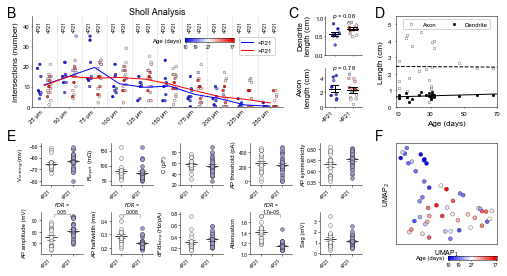

In [4]:
fig, axes = generate_figures.generate_figure_06()

sholl_analysis.plot_intersections(df, axes['B'])
plot_comparisons(df, axes['C1'], axes['C2'])
sholl_analysis.plot_fit(df, axes['D'])
plot_ephys(fig, df_ephys, df_ephys_labels, axes['F'])

fig.savefig('Figures/Figure Sholl.pdf')

packet = io.BytesIO()

#move to the beginning of the StringIO buffer
packet.seek(0)

# read your existing PDF
existing_pdf_1 = PdfFileReader(open("Figures/Figure Sholl - Lin.pdf", "rb"))
existing_pdf_2 = PdfFileReader(open("Figures/Figure Sholl.pdf", "rb"))
output = PdfFileWriter()

# add the "watermark" (which is the new pdf) on the existing page
page = existing_pdf_1.getPage(0)
page.mergeTranslatedPage(existing_pdf_2.getPage(0), 0, 110, expand=False)
output.addPage(page)
# finally, write "output" to a real file
outputStream = open("Figures/Figure 6.pdf", "wb")
output.write(outputStream)
outputStream.close()